In [1]:
import numpy as np
import xarray as xr
import metpy 
import pandas as pd
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import statsmodels.api as sm
from scipy import stats

In [2]:
pwd

'/home/jstancz/mjo_scripts'

In [5]:
file = '/home/jstancz/data/kf_python_precip_3.nc'
file2 = '/home/jstancz/Desktop/groups/ORC-CLIMATE/aoes_repo/obs/MSWEP_daily/MSWEP_201*.nc'

In [6]:
ds_filtered = xr.open_dataset(file)
ds_mswep = xr.open_mfdataset(file2,combine='nested',concat_dim='time')


In [7]:
ds_filtered

<xarray.Dataset> Size: 52kB
Dimensions:    (time: 2575)
Coordinates:
  * time       (time) datetime64[ns] 21kB 2011-04-01 2011-04-02 ... 2018-04-18
    dayofyear  (time) int64 21kB ...
Data variables:
    p_mjo      (time) float32 10kB ...

In [8]:
ds_mswep

<xarray.Dataset> Size: 154MB
Dimensions:    (time: 3652, latitude: 73, longitude: 144)
Coordinates:
  * time       (time) datetime64[ns] 29kB 2010-01-01 2010-01-02 ... 2019-12-31
  * latitude   (latitude) float32 292B -90.0 -87.5 -85.0 ... 85.0 87.5 90.0
  * longitude  (longitude) float32 576B 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
Data variables:
    precip     (time, latitude, longitude) float32 154MB dask.array<chunksize=(365, 73, 144), meta=np.ndarray>

In [9]:
#working with the latitudinally averaged 10S to 10N precip


#Set domain
lon_min = 0
lon_max = 360
lat_max = 10
lat_min = -10

# Define the months for December through April
#selected_months = [12, 1, 2, 3]

# Slice the dataset for the specified time range and spatial bounds
ds_mswep = ds_mswep.sel(time=slice('2011-04-01', '2018-04-18'),
                       longitude=slice(lon_min, lon_max),
                       latitude=slice(lat_min, lat_max))




# Use .dt accessor and the isin() method to filter only December through April
#ds_mswep = ds_mswep.sel(time=ds_mswep['time'].dt.month.isin(selected_months))

In [10]:
ds_mswep

<xarray.Dataset> Size: 13MB
Dimensions:    (time: 2575, latitude: 9, longitude: 144)
Coordinates:
  * time       (time) datetime64[ns] 21kB 2011-04-01 2011-04-02 ... 2018-04-18
  * latitude   (latitude) float32 36B -10.0 -7.5 -5.0 -2.5 0.0 2.5 5.0 7.5 10.0
  * longitude  (longitude) float32 576B 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
Data variables:
    precip     (time, latitude, longitude) float32 13MB dask.array<chunksize=(275, 9, 144), meta=np.ndarray>

In [11]:
def anomalies(ds):
    var = ds.groupby("time.dayofyear")
    climo = ds.groupby("time.dayofyear").mean()
    anom = var - climo
    return anom

In [12]:
#calculate precip anomalies for the 10S to 10N for all lons
precip_anom = anomalies(ds_mswep)
precip_anom_avg = precip_anom.mean(dim=['latitude'])
precip_anom_avg
precip_anom_avg = precip_anom_avg['precip']
precip_anom_avg

<xarray.DataArray 'precip' (time: 2575, longitude: 144)> Size: 1MB
dask.array<mean_agg-aggregate, shape=(2575, 144), dtype=float32, chunksize=(1, 144), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 21kB 2011-04-01 2011-04-02 ... 2018-04-18
  * longitude  (longitude) float32 576B 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
    dayofyear  (time) int64 21kB 91 92 93 94 95 96 ... 103 104 105 106 107 108

In [15]:
precip_index_filtered = ds_filtered['p_mjo']
precip_index_filtered

<xarray.DataArray 'p_mjo' (time: 2575)> Size: 10kB
[2575 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 21kB 2011-04-01 2011-04-02 ... 2018-04-18
    dayofyear  (time) int64 21kB ...

In [16]:
# Define lag range
lags = np.arange(-20, 21)  # Lags from -20 to +20 days

# Initialize arrays to store regression coefficients
regression_coefficient = xr.DataArray(
    np.zeros((len(lags), len(precip_anom_avg.longitude))),
    dims=["lag", "longitude"],
    coords={"lag": lags, "longitude": precip_anom_avg.longitude}
)



# Loop over each lag

for i, lag in enumerate(lags):
    print(f"Processing lag: {lag} ({i + 1}/{len(lags)})")
    
    # Shift the precip_index based on the lag
    shifted_index = precip_index_filtered.shift(time=lag)
    
     # Calculate mean for precipitation data vs index
    mean_precip = precip_anom_avg.mean(dim='time')
    mean_index = shifted_index.mean(dim='time')
    

    # Calculate deviations and regression coefficients for precipitation
    dev_precip = precip_anom_avg - mean_precip
    dev_p_index = shifted_index - mean_index
    
    
    # Calculate regression coefficient for precipitation
    covar = (dev_precip * dev_p_index).sum(dim='time')
    var = (dev_p_index ** 2).sum(dim='time')
    
    
    regression_coefficient.loc[dict(lag=lag)] = covar/ var

    #regression_coefficient_u.loc[dict(lag=lag)] = covar/ var

# Compute the results
regression_coefficient = regression_coefficient.compute()
#regression_coefficient_u = regression_coefficient.compute()

Processing lag: -20 (1/41)
Processing lag: -19 (2/41)
Processing lag: -18 (3/41)
Processing lag: -17 (4/41)
Processing lag: -16 (5/41)
Processing lag: -15 (6/41)
Processing lag: -14 (7/41)
Processing lag: -13 (8/41)
Processing lag: -12 (9/41)
Processing lag: -11 (10/41)
Processing lag: -10 (11/41)
Processing lag: -9 (12/41)
Processing lag: -8 (13/41)
Processing lag: -7 (14/41)
Processing lag: -6 (15/41)
Processing lag: -5 (16/41)
Processing lag: -4 (17/41)
Processing lag: -3 (18/41)
Processing lag: -2 (19/41)
Processing lag: -1 (20/41)
Processing lag: 0 (21/41)
Processing lag: 1 (22/41)
Processing lag: 2 (23/41)
Processing lag: 3 (24/41)
Processing lag: 4 (25/41)
Processing lag: 5 (26/41)
Processing lag: 6 (27/41)
Processing lag: 7 (28/41)
Processing lag: 8 (29/41)
Processing lag: 9 (30/41)
Processing lag: 10 (31/41)
Processing lag: 11 (32/41)
Processing lag: 12 (33/41)
Processing lag: 13 (34/41)
Processing lag: 14 (35/41)
Processing lag: 15 (36/41)
Processing lag: 16 (37/41)
Processin

In [17]:
# Create an array of lags from -10 to 10
lags_10 = np.arange(-10, 11)

# Initialize lists to store max slope values and corresponding longitudes
max_slope_values = []
corresponding_longitudes = []

# Loop through each lag to find the maximum slope and its corresponding longitude
for lag in lags_10:
    # Select the maximum coefficient for the current lag across longitudes
    max_slope_value = regression_coefficient.sel(lag=lag).max(dim='longitude')
    max_slope_values.append(max_slope_value)

    # Get the index of the longitude where this max slope occurs
    max_longitude_index = regression_coefficient.sel(lag=lag).argmax(dim='longitude')
    max_longitude = precip_anom_avg.longitude[max_longitude_index].values
    corresponding_longitudes.append(max_longitude)

# Convert lists to numpy arrays for regression
max_slope_values = np.array(max_slope_values)
corresponding_longitudes = np.array(corresponding_longitudes)

# Perform linear regression on corresponding longitudes and lags
slope, intercept, r_value, p_value, std_err = stats.linregress(corresponding_longitudes, lags_10)

# Determine the x-axis limits of the contour plot
x_min = 95
x_max = 207.5

# Generate the regression line for the x-axis limits so it doesn't go off the plot
regression_xlim = np.linspace(x_min, x_max, num=100)
regression_line = slope * regression_xlim + intercept

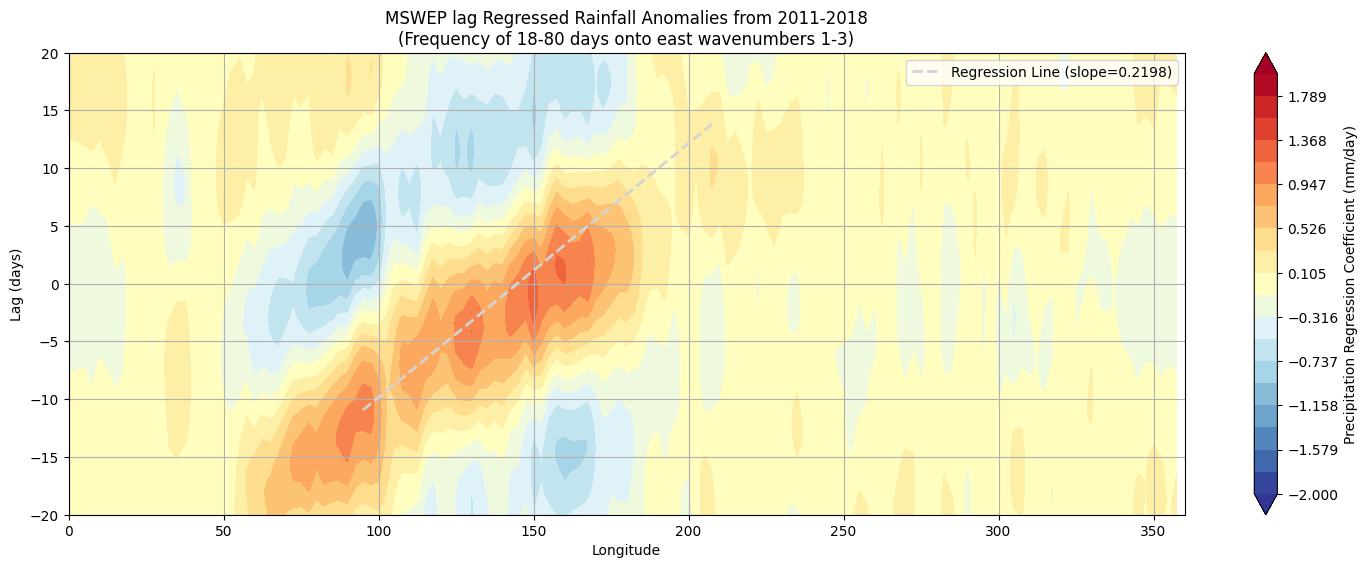

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Set figure size
plt.figure(figsize=(18, 6))

# Plot filled contours for precipitation regression coefficients
cf = plt.contourf(precip_anom_avg.longitude, lags, regression_coefficient, 
                             cmap='RdYlBu_r', levels=np.linspace(-2, 2, 20), extend='both')

# Plot contour for U-winds
#contour_lines = plt.contour(u_anom_avg.longitude, lags, regression_coefficient_u_sd, 
                            #levels=np.linspace(-1, 1, 8 ),  # Levels from -1 to 1, every 0.5 units
                            #colors='black', linewidths=0.75)  # Contour line aesthetics

# Color bar
cbar = plt.colorbar(cf, label='Precipitation Regression Coefficient (mm/day)')

# Overlay the regression line across the determined limits
plt.plot(regression_xlim, regression_line, color='lightgrey', linestyle='--', linewidth=2, 
         label=f'Regression Line (slope={slope:.4f})')  # Corrected closing parenthesis

# Axis labels and title
plt.xlabel('Longitude')
plt.ylabel('Lag (days)')
plt.title("MSWEP lag Regressed Rainfall Anomalies from 2011-2018\n"
          "(Frequency of 18-80 days onto east wavenumbers 1-3)")

# Add grid and show plot
plt.grid(True)
plt.legend()
plt.xlim([0, 360])
plt.ylim(-20, 20)  

path = '/home/jstancz/mjo_plots/'

filename = 'Py_kf_mjo.jpg'

#plt.savefig(path + filename, dpi=700)

plt.show()
